# Machine learning case studies HW 1
## Time series

### Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Data reading

In [2]:
csv_path = '../data/DataSet_Tesco5000_withDaynum.csv'
df = pd.read_csv(csv_path)
df.head()

,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
1,2,2010-04-06,12.71,5
2,2,2010-04-07,34.52,6
3,2,2010-04-12,7.89,11
4,2,2010-04-14,17.17,13


In [3]:
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')

In [4]:
print(df.dtypes)
print(df.info)
df.head()

customer_id             int64
visit_date     datetime64[ns]
visit_spend           float64
daynum                  int64
dtype: object
<bound method DataFrame.info of         customer_id visit_date  visit_spend  daynum
0                 2 2010-04-01         5.97       0
1                 2 2010-04-06        12.71       5
2                 2 2010-04-07        34.52       6
3                 2 2010-04-12         7.89      11
4                 2 2010-04-14        17.17      13
...             ...        ...          ...     ...
596728         7376 2011-05-15         4.86     409
596729         7376 2011-05-24        56.55     418
596730         7376 2011-05-26        60.25     420
596731         7376 2011-06-09       159.15     434
596732         7376 2011-06-19         5.98     444

[596733 rows x 4 columns]>


,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
1,2,2010-04-06,12.71,5
2,2,2010-04-07,34.52,6
3,2,2010-04-12,7.89,11
4,2,2010-04-14,17.17,13


In [5]:
daily_revenue = (
    df.groupby('visit_date')['visit_spend']
    .sum()
    .reset_index()
    .sort_values("visit_date")
)

In [6]:
daily_revenue.columns = ["date", "revenue"]
daily_revenue

,date,revenue
0,2010-04-01,102625.86
1,2010-04-02,82660.90
2,2010-04-03,78081.71
3,2010-04-04,4411.05
4,2010-04-05,38144.77
...,...,...
439,2011-06-15,51252.38
440,2011-06-16,68920.34
441,2011-06-17,80762.94
442,2011-06-18,81009.66


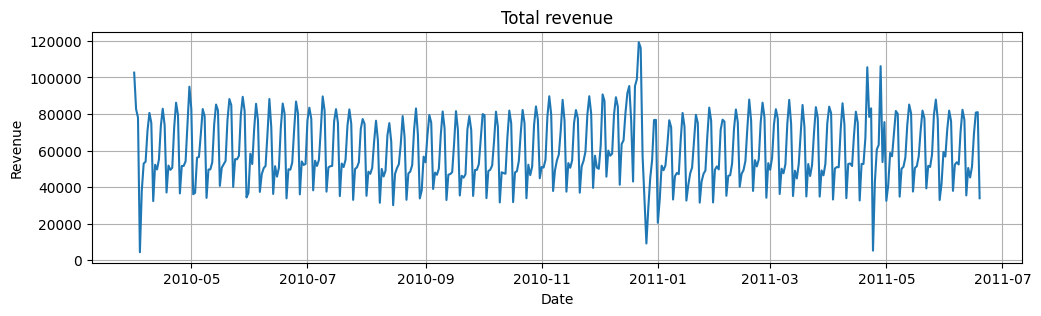

In [7]:
plt.figure(figsize=(12,3))
plt.plot(daily_revenue["date"], daily_revenue["revenue"])
plt.title("Total revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

In [8]:
daily_revenue["day_of_week"] = daily_revenue["date"].dt.dayofweek
daily_revenue["month"] = daily_revenue["date"].dt.month
daily_revenue["year"] = daily_revenue["date"].dt.year

In [9]:
daily_revenue.tail()

,date,revenue,day_of_week,month,year
439,2011-06-15,51252.38,2,6,2011
440,2011-06-16,68920.34,3,6,2011
441,2011-06-17,80762.94,4,6,2011
442,2011-06-18,81009.66,5,6,2011
443,2011-06-19,33933.16,6,6,2011


### Baseline

In [10]:
daily_revenue["baseline_pred"] = daily_revenue["revenue"].shift(14)
daily_revenue.head(16)

,date,revenue,day_of_week,month,year,baseline_pred
0,2010-04-01,102625.86,3,4,2010,NaN
1,2010-04-02,82660.90,4,4,2010,NaN
2,2010-04-03,78081.71,5,4,2010,NaN
3,2010-04-04,4411.05,6,4,2010,NaN
4,2010-04-05,38144.77,0,4,2010,NaN
5,2010-04-06,52928.27,1,4,2010,NaN
6,2010-04-07,53908.71,2,4,2010,NaN
7,2010-04-08,70863.75,3,4,2010,NaN
8,2010-04-09,80590.71,4,4,2010,NaN
9,2010-04-10,75106.49,5,4,2010,NaN


In [11]:
last_day = daily_revenue["date"].max()
print(last_day.date())

2011-06-19


In [12]:
eval_start = last_day - pd.Timedelta(days=89)
eval_end = last_day
print("Evaluation period:", eval_start.date(), "to", eval_end.date())

Evaluation period: 2011-03-22 to 2011-06-19


In [13]:
fridays = daily_revenue[
    (daily_revenue["date"] >= eval_start) &
    (daily_revenue["date"] <= eval_end) &
    (daily_revenue["date"].dt.dayofweek == 4)
]["date"].to_list()


In [14]:
print(fridays)

[Timestamp('2011-03-25 00:00:00'), Timestamp('2011-04-01 00:00:00'), Timestamp('2011-04-08 00:00:00'), Timestamp('2011-04-15 00:00:00'), Timestamp('2011-04-22 00:00:00'), Timestamp('2011-04-29 00:00:00'), Timestamp('2011-05-06 00:00:00'), Timestamp('2011-05-13 00:00:00'), Timestamp('2011-05-20 00:00:00'), Timestamp('2011-05-27 00:00:00'), Timestamp('2011-06-03 00:00:00'), Timestamp('2011-06-10 00:00:00'), Timestamp('2011-06-17 00:00:00')]


In [15]:

predictions = []
for friday in fridays: 
    forecast_days = pd.date_range(friday, friday + pd.Timedelta(days=6), freq='D') # forecast for 7 days
    # print("Forecast period:", forecast_days[0].date(), "to", forecast_days[-1].date())
    
    for day in forecast_days:
        
        ref_day = day - pd.Timedelta(days=14)
        
        if ref_day in daily_revenue["date"].values:
            y_hat = daily_revenue.loc[daily_revenue["date"] == ref_day, "revenue"].values[0]
        else:
            y_hat = None  # No prediction at the beggining
    
        if day in daily_revenue["date"].values:
            y_true = daily_revenue.loc[daily_revenue["date"] == day, "revenue"].values[0]
        else:
            y_true = None  # No true value at the future
    
        predictions.append({
            "date": friday,
            "target_date": day,
            "y_true": y_true,
            "y_pred_bl": y_hat
        })

In [16]:
baseline_preds = pd.DataFrame(predictions)

baseline_preds = baseline_preds[
    (baseline_preds["target_date"] >= eval_start) &
    (baseline_preds["target_date"] <= eval_end)
].reset_index(drop=True)

print(baseline_preds.__len__()) # should be less than 90 days?

87


In [20]:
eval_df = baseline_preds.dropna(subset=["y_true", "y_pred_bl"])

y_true = eval_df["y_true"].values
y_pred = eval_df["y_pred_bl"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
smape = 100 * np.mean(
    2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
)

print(f"  MAE  = {mae:.2f}")
print(f"  RMSE = {rmse:.2f}")
print(f"  sMAPE = {smape:.2f}%")


  MAE  = 6816.97
  RMSE = 11175.05
  sMAPE = 13.00%


### MAE
Approx. 6800 error on each day.
### RMSE
Approx. 11175 root mean squared error. It's sensitive for large outliers. Probably big sales, holidays etc.
### sMAPE
Symmetric Mean Absolute Percentage Error. Unit idependet error percentage. Approx. 13 % is an acceptable performance.